# B2 Galaxy Cluster Injection


In this notebook we inject a synthetic galaxy cluster into a DC2 simulated catalog, and render them together into an image.

We will also apply gravitational shear, in accordance with the lens geometry


## Objectives

    1 Learn to inject a galaxy cluster at the catalog level
    
    2 Apply shear to background sources, based on lens geometry


## Setup

This notebook relies on the:

    * synthetic package & dependencies
    
    * DC2 cutotut data files on disk
    
    * curated galaxy cluster member catalog (A4 notebook)
    
    * package to render catalogs into images (B1 notebook)


## Output

    * fits image in g, r, i band with cluster injected
    
    * color composite image for visualization with cluster injected
 
    
The output files are placed in the `./data/` folder


## Contact

In case of questions, contact me at t.varga@physik.lmu.de

In [1]:
import fitsio as fio
import numpy as np
import pandas as pd
import pickle as pickle
import copy
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.cosmology as cosmology

import images # package from erin sheldon

import synthetic.tools as tools
import synthetic.render.frame as frame
import synthetic.render.render as render


pixel_scale = 0.2

*** Important *** set the `nprocess` value to the amount of CPU cores you are willing or allowed to use for this notebook

please consider your local server, e.g. don't run heavy calculations on public login nodes

In [4]:
nprocess = 4

In [5]:
# output path for mock image, be sure to place it into a folder where you can write a few GBs of files 
out_path = "./data/"

# Prepare the DC2 data

This is largely identical to the B1 tutorial

Now we load an arbitrary chunk of DC2, in this case orderedd by a list of healpix pixel cutotuts.

In [6]:
table_path = './data/refdata/curated_table.h5'
table = pd.read_hdf(table_path, key="data")

ra_cen = 50.64516228577292
dec_cen = -40.228830895890404

mock_catalog_path = './data/refdata/curated_mock_catalog.h5'
mock_catalog = pd.read_hdf(mock_catalog_path, key="data")

# Create a shear profile

**NOTE** In truth, the shear profile, the mass profile, the mass and the optical properties of galaxy clusters are correlated. Unfortunately this correlation is poorly constrained at present. For this reason the cautious approach is to not assume an explicit relation, and allow us the explore, and marginalize over many different connections. In the below example we take a simple isothermal (power law) profile, to illustrate that we are able to imprint an arbitrarily chosen shear profile.


In case you have other preferences, the below section is where you must modify the line-of-sight catalog. You can add magnification, or other shear profiles as your preferences dictate




In [7]:
cosmo = cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

In [8]:
image_offset=(2499.5, 2499.5)

xra = (mock_catalog['X'] - image_offset[0]) * pixel_scale / 60 # arcmin
ydec = (mock_catalog['Y'] - image_offset[1]) * pixel_scale / 60 # arcmin
dists = np.sqrt(xra**2 + ydec**2)

shears = np.sqrt(1 / dists  / 400) # just for illustration purposes
shears[shears > 0.8] = 0.8 # galsim cannot render very large shears properly

phis =  np.arctan2(ydec, xra)
es1 = (-1. * shears * np.cos(2 * phis))
es2 = (-1. * shears * np.sin(2 * phis))


e1 = mock_catalog['G1']
e2 = mock_catalog['G2']
vals1 = e1 + es1 - e1 * es1 - e2 * es2 # Calculate the sheared galaxy shape
vals2 = e2 + es2 - es1 * e2 + es2 * e1

tmp = np.sqrt(vals1**2. + vals2**2.)
ii = tmp > 0.9 # galsim cannot render very large shears properly, we must reduce the 
divs = 1. / (0.1 + tmp[ii])  
vals1[ii] *= divs
vals2[ii] *= divs

# Add shear only to galaxies, which are at z > 0.4,
# this is a super simple approximation, intended to showcase the functionality
jj = table['redshift_true'] > 0.4

mock_catalog.loc[jj, "G1"] = vals1[jj]
mock_catalog.loc[jj, "G2"] = vals2[jj]

## Test the tangential shear profile

In [9]:
def get_tangential(xpos, ypos, e1, e2, center):
    """The center is where th aperture is"""
    dists = np.sqrt((ypos - center[1])**2. + (xpos - center[0])**2.)
    phis = np.arctan2(ypos - center[1], xpos - center[0])
    tshears = -e1 * np.cos(2 * phis) - e2 * np.sin(2 * phis)
    return tshears, dists

In [10]:
tshear, rarr = get_tangential(mock_catalog["X"], mock_catalog["Y"], es1, es2, (2499.5, 2499.5))

Text(0, 0.5, '$\\gamma_t$')

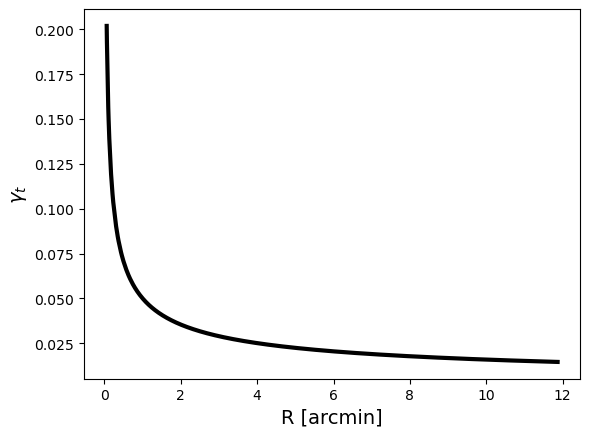

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

# plot the truth curve
iorder = np.argsort(dists)
ax.plot(dists.iloc[iorder], shears.iloc[iorder], color="black", zorder=4, lw=3, label="true input e_t")
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("R [arcmin]", fontsize=14)
ax.set_ylabel("$\\gamma_t$", fontsize=14)

Text(0, 0.5, '$\\gamma_t$')

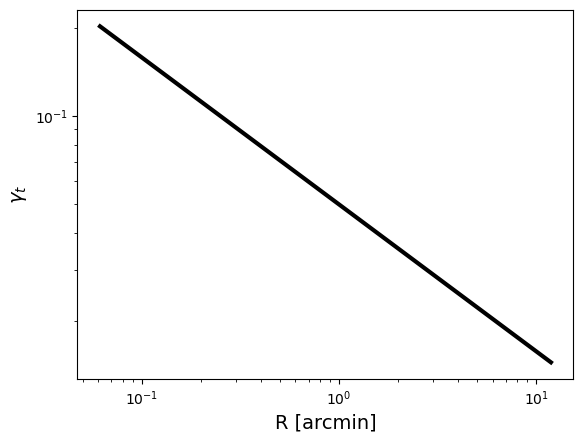

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

# plot the truth curve
iorder = np.argsort(dists)
ax.plot(dists.iloc[iorder], shears.iloc[iorder], color="black", zorder=4, lw=3, label="true input e_t")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("R [arcmin]", fontsize=14)
ax.set_ylabel("$\\gamma_t$", fontsize=14)

# Render cluster injection

For this example, we are going to use a curated galaxy cluster member catalog

First we are loading cluster member catalog

In [29]:
mock_cluster_path = './data/refdata/curated_cluster_model_v01-z0l0_15000_001.h5'
mock_cluster = pd.read_hdf(mock_cluster_path, key="data")

For this example, this is saved in the same database format (exact same columns) as the DC2 catalog which we used above, so we can simply concatenate them in pandas

In [30]:
mock_all = pd.concat((mock_cluster, mock_catalog))

***Note, you determine how many CPUs are used in the header part of this notebook**
by setting the `nprocess` value

In [31]:
# These are the approcimate noise levels we are going to use for mock images in this notebook
# g, r, i, z bands
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3

# This is the file name root, appended by bands
# we render only g, r, i as those already make a nice color image
file_name_tag = 'test_cluster_canvas_dc2_' #

for i, band in enumerate(("g", "r", "i")):
    name = out_path + file_name_tag + band
    print(name)
    fr = frame.Frame(mock_all.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render(nprocess=nprocess) 

./data/test_cluster_canvas_dc2_g
starting postage stamp calculations in 4 processes
./data/test_cluster_canvas_dc2_r
starting postage stamp calculations in 4 processes
./data/test_cluster_canvas_dc2_i
starting postage stamp calculations in 4 processes


the above script renders the cluster and the pre-injection line of sight together.

Since this is a synthetic scenario, we can render the cluster only too, with much lower noise

(Rendering the regular line-of-sight was covered in the previous tutorial B1)

In [32]:
# stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3
# for i, band in enumerate(("g", "r", "i")):
#     name = folder_path + 'test_v2_canvas_grid_low-isothermal_' + band
#     print(name)
#     fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
#                      center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
#     fr.render() 

In [33]:
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) * 1e-5

# This is the file name root, appended by bands
# we render only g, r, i as those already make a nice color image
file_name_tag = 'test_cluster-only_canvas_dc2_' #

for i, band in enumerate(("g", "r", "i")):
    name = out_path + file_name_tag + band
    print(name)
    fr = frame.Frame(mock_cluster.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render(nprocess=nprocess) 

./data/test_cluster-only_canvas_dc2_g
starting postage stamp calculations in 4 processes
./data/test_cluster-only_canvas_dc2_r
starting postage stamp calculations in 4 processes
./data/test_cluster-only_canvas_dc2_i
starting postage stamp calculations in 4 processes


Now we load in the rendered images, so that we can make a visualization out of them

In [34]:
ims_all = []
for i, band in enumerate(("g", "r", "i")):
    name = out_path + 'test_cluster_canvas_dc2_' + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_all.append(tmp)
    
ims_clust = []
for i, band in enumerate(("g", "r", "i")):
    name = out_path + 'test_cluster-only_canvas_dc2_' + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_clust.append(tmp)    

./data/test_cluster_canvas_dc2_g.fits
./data/test_cluster_canvas_dc2_r.fits
./data/test_cluster_canvas_dc2_i.fits
./data/test_cluster-only_canvas_dc2_g.fits
./data/test_cluster-only_canvas_dc2_r.fits
./data/test_cluster-only_canvas_dc2_i.fits


So that we obtain a galaxy cluster rendered together with the local DC cutout.

The injection is added,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.869175910949707


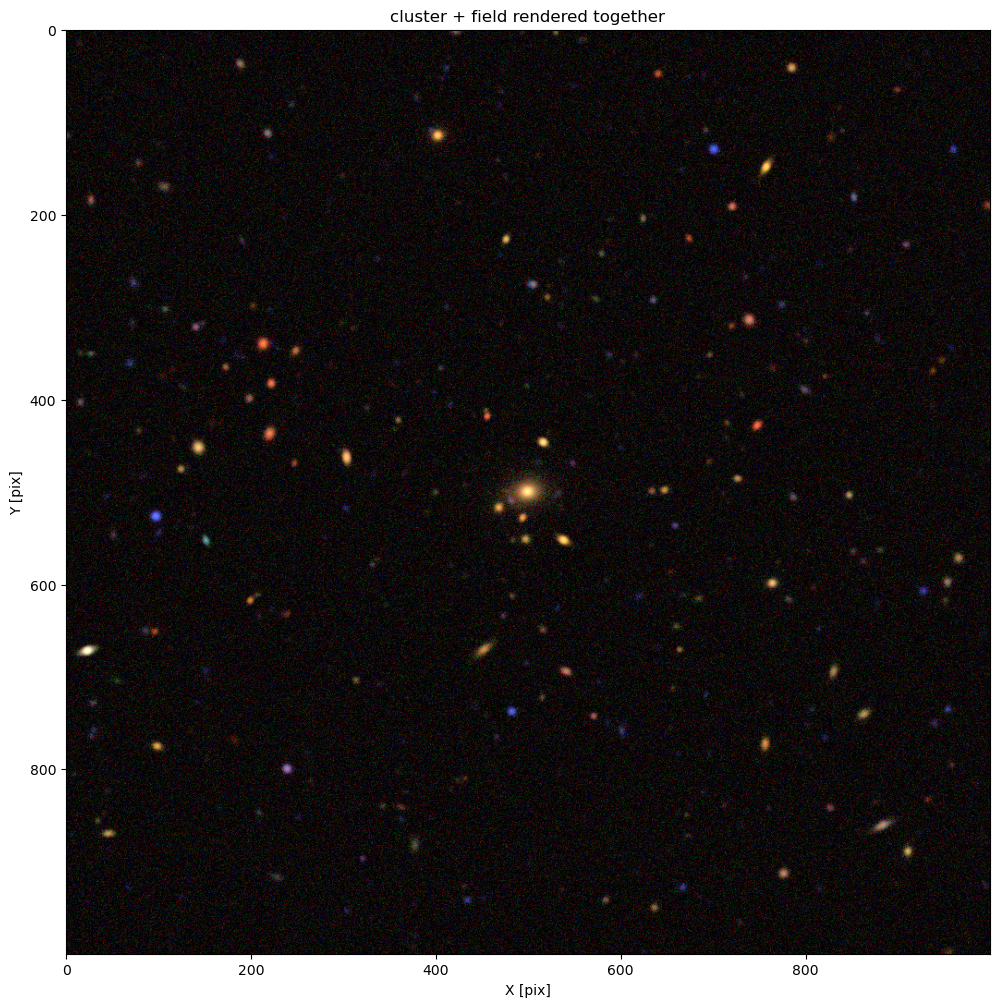

In [35]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2] + pad,
                                ims_all[1] + pad,
                                ims_all[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2000:3000, 2000:3000] * 2, origin='upper')

ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("./data/dc2_hp_clust.png", bbox_inches='tight')

and we can also render the injected cluster alone. Note that for this we did not yet add the intra cluster light model (ICL), which is a diffuse outer light envelope around the central galaxy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.6996209621429443


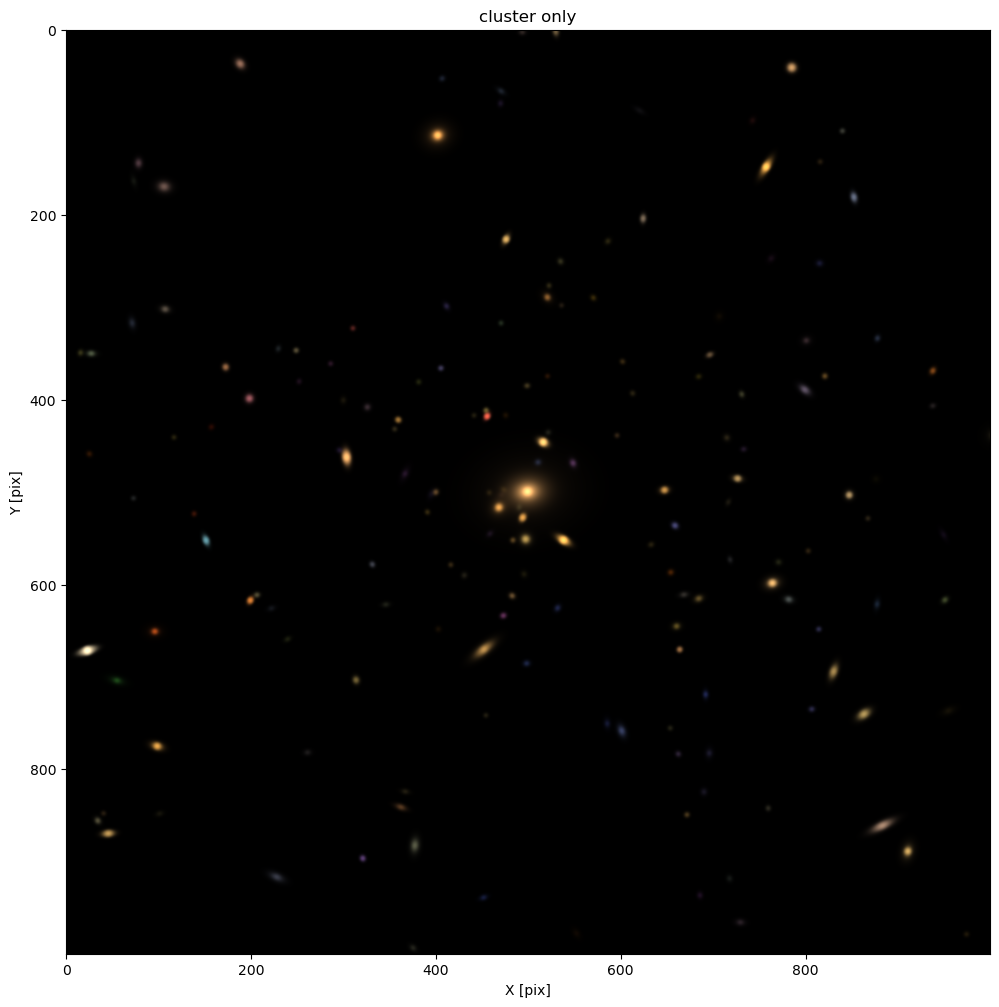

In [36]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_clust[2] + pad,
                                ims_clust[1] + pad,
                                ims_clust[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2000:3000, 2000:3000] * 2, origin='upper')

ax.set_title("cluster only")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("./data/dc2_hp_clust-only.png", bbox_inches='tight')